### Load Config

In [2]:
from yaml import load, Loader
from bunch import Bunch
Bunch.__str__ = Bunch.__repr__

stream = open("config.yaml", 'r')
config = Bunch(load(stream, Loader=Loader))

### Visualize Results

#### Feature-based

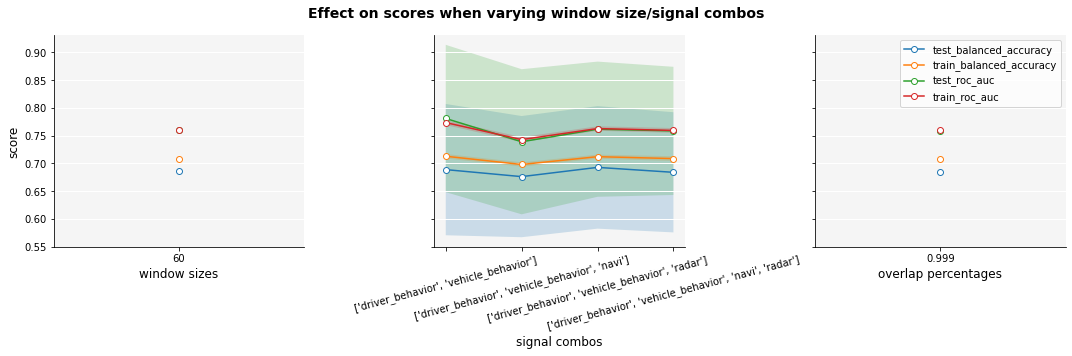

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotting_util as putil

plt.rcParams['figure.facecolor'] = 'white'

SIGNAL_COMBOS = [['driver_behavior', 'vehicle_behavior'], ['driver_behavior', 'vehicle_behavior', 'navi'],
                ['driver_behavior', 'vehicle_behavior', 'radar'], ['driver_behavior', 'vehicle_behavior', 'navi', 'radar']]

scores = ['test_balanced_accuracy', 'train_balanced_accuracy', 'test_roc_auc', 'train_roc_auc']

fig, axes = putil.create_plot(nrows=1, ncols=3, sharey=True)
for ax in axes:
    putil.set_ax_visible_spines(ax, top=False, right=False)
putil.set_figure_size(fig, 15, 5)

# compare window sizes
avg_scores = []
avg_stddev = []
for window_size in config.window_sizes:
    avg_mean_scores = []
    stddev = []
    for combo in SIGNAL_COMBOS:
        signal_string = ''
        for signal in combo:
            signal_string += '_' + signal

        for scenario in ['highway', 'rural', 'town']:
            results = pd.read_csv('out/results/{}_pred_results_windowsize_{}_step_size_1s{}_{}.csv'.format(
                        config.classifier, window_size, signal_string, scenario), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
            avg_mean_scores.append(results.loc['mean', scores])
            stddev.append(results.loc['stddev', scores])
    avg_mean_scores = np.array(avg_mean_scores).mean(axis=0)
    stddev = np.array(stddev).mean(axis=0)
    avg_scores.append(avg_mean_scores)
    avg_stddev.append(stddev)
avg_scores = np.array(avg_scores)
avg_stddev = np.array(avg_stddev)
for i in range(avg_scores.shape[1]):
    axes[0].plot(config.window_sizes, avg_scores[:, i], markerfacecolor='white', marker="o", label=scores[i])
    axes[0].fill_between(config.window_sizes, y1=avg_scores[:, i]-avg_stddev[:, i], y2=avg_scores[:, i]+avg_stddev[:, i], alpha=0.2)
putil.set_ax_xticks(axes[0], config.window_sizes, config.window_sizes)
putil.set_ax_axis_labels(axes[0], x_label='window sizes', y_label='score')
putil.set_ax_bg_color(axes[0], 'whitesmoke')
putil.set_ax_grid_lines(axes[0], True, axis="y", color="w")

# compare signal combos
avg_scores = []
avg_stddev = []
for combo in SIGNAL_COMBOS:
    avg_mean_scores = []
    mean_stddev = []
    for window_size in config.window_sizes:
        signal_string = ''
        for signal in combo:
            signal_string += '_' + signal

        for scenario in ['highway', 'rural', 'town']:
            results = pd.read_csv('out/results/{}_pred_results_windowsize_{}_step_size_1s{}_{}.csv'.format(
                        config.classifier, window_size, signal_string, scenario), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
            avg_mean_scores.append(results.loc['mean', scores])
            mean_stddev.append(results.loc['stddev', scores])
    avg_mean_scores = np.array(avg_mean_scores).mean(axis=0)
    mean_stddev = np.array(mean_stddev).mean(axis=0)
    avg_scores.append(avg_mean_scores)
    avg_stddev.append(mean_stddev)
avg_scores = np.array(avg_scores)
avg_stddev = np.array(avg_stddev)
for i in range(avg_scores.shape[1]):
    axes[1].plot(range(len(avg_scores)), avg_scores[:, i], markerfacecolor='white', marker="o", label=scores[i])
    axes[1].fill_between(range(len(avg_scores)), y1=avg_scores[:, i]-avg_stddev[:, i], y2=avg_scores[:, i]+avg_stddev[:, i], alpha=0.2)
putil.set_ax_xticks(axes[1], range(len(avg_scores)), SIGNAL_COMBOS, rotation=15)
putil.set_ax_axis_labels(axes[1], 'signal combos')
putil.set_ax_bg_color(axes[1], 'whitesmoke')
putil.set_ax_grid_lines(axes[1], True, axis="y", color="w")

# compare step sizes
avg_scores = []
avg_stddev = []
for overlap_percentage in config.overlap_percentages:
    avg_mean_scores = []
    mean_stddev = []
    for window_size in config.window_sizes:
        step = 1
        if overlap_percentage is not None:
            step = window_size - int(overlap_percentage * window_size)
        signal_string = ''
        for signal in SIGNAL_COMBOS[-1]:
            signal_string += '_' + signal

        for scenario in ['highway', 'rural', 'town']:
            results = pd.read_csv('out/results/{}_pred_results_windowsize_{}_step_size_{}s{}_{}.csv'.format(
                        config.classifier, window_size, step, signal_string, scenario), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
            avg_mean_scores.append(results.loc['mean', scores])
            mean_stddev.append(results.loc['stddev', scores])
    avg_mean_scores = np.array(avg_mean_scores).mean(axis=0)
    mean_stddev = np.array(mean_stddev).mean(axis=0)
    avg_scores.append(avg_mean_scores)
    avg_stddev.append(mean_stddev)
avg_scores = np.array(avg_scores)
avg_stddev = np.array(avg_stddev)
for i in range(avg_scores.shape[1]):
    axes[2].plot(range(len(avg_scores)), avg_scores[:, i], markerfacecolor='white', marker="o", label=scores[i])
    axes[2].fill_between(range(len(avg_scores)), y1=avg_scores[:, i]-avg_stddev[:, i], y2=avg_scores[:, i]+avg_stddev[:, i], alpha=0.2)
xticks = config.overlap_percentages.copy()
xticks[-1] = '0.999'
putil.set_ax_xticks(axes[2], range(len(avg_scores)), xticks)
putil.set_ax_axis_labels(axes[2], 'overlap percentages')
putil.set_ax_bg_color(axes[2], 'whitesmoke')
putil.set_ax_grid_lines(axes[2], True, axis="y", color="w")

plt.legend()
putil.set_fig_title(fig, title='Effect on scores when varying window size/signal combos', font_size=14, font_weight='bold')
plt.tight_layout()
plt.savefig('out/results/{}_scores_varying_window_size_signal_combos_step_size.png'.format(config.classifier))

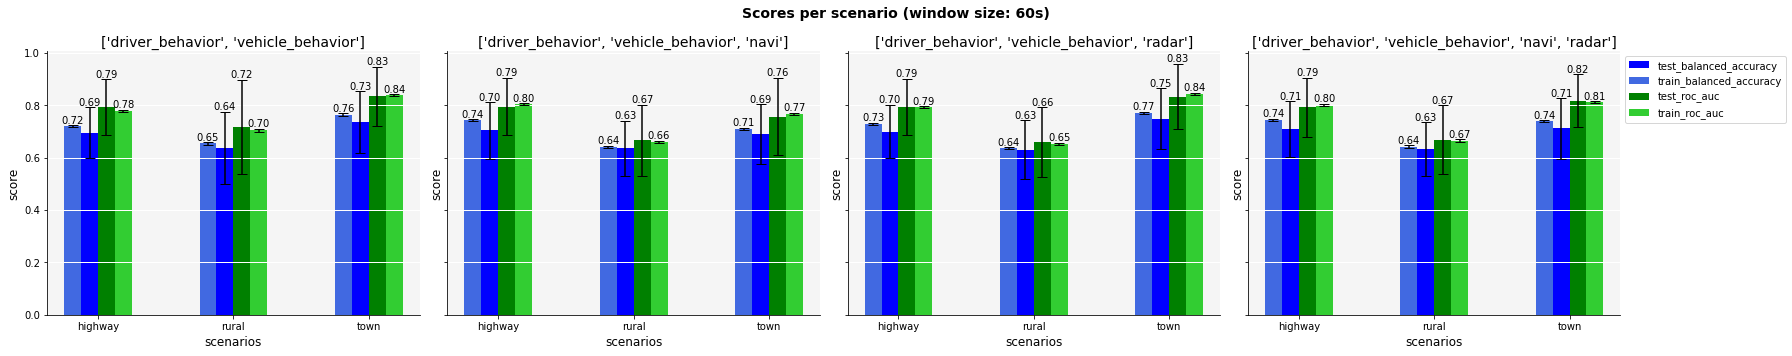

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotting_util as putil

plt.rcParams['figure.facecolor'] = 'white'

SIGNAL_COMBOS = [['driver_behavior', 'vehicle_behavior'], ['driver_behavior', 'vehicle_behavior', 'navi'],
                ['driver_behavior', 'vehicle_behavior', 'radar'], ['driver_behavior', 'vehicle_behavior', 'navi', 'radar']]

SCENARIOS = ['highway', 'rural', 'town']

scores = ['test_balanced_accuracy', 'train_balanced_accuracy', 'test_roc_auc', 'train_roc_auc']

fig, axes = putil.create_plot(nrows=1, ncols=len(SIGNAL_COMBOS), sharey=True)
for ax in axes:
    putil.set_ax_visible_spines(ax, top=False, right=False)
putil.set_figure_size(fig, 25, 5)

colors = ['blue', 'royalblue', 'green', 'limegreen']
# compare scenarios
for i, scenario in enumerate(SCENARIOS):
    for j, window_size in enumerate(config.window_sizes):
        for k, combo in enumerate(SIGNAL_COMBOS):
            mean_scores = []
            mean_stddev = []
            signal_string = ''
            for signal in combo:
                signal_string += '_' + signal
            results = pd.read_csv('out/results/{}_pred_results_windowsize_{}_step_size_1s{}_{}.csv'.format(
                            config.classifier, window_size, signal_string, scenario), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
            mean_scores.append(results.loc['mean', scores])
            mean_stddev.append(results.loc['stddev', scores])
            mean_scores = np.array(mean_scores).mean(axis=0)
            mean_stddev = np.array(mean_stddev).mean(axis=0)
            width = 0.5
            frac = width/len(scores)
            for l in range(len(scores)):
                if l < len(scores) / 2:
                    b = axes[k].bar(i+1 - (l+1)*frac, mean_scores[l], frac, yerr=mean_stddev[l], label=scores[l], color=colors[l], align='edge', capsize=5)
                    axes[k].bar_label(b, fmt='%.2f')
                else:
                    b = axes[k].bar(i+1 + (l-(len(scores)//2))*frac, mean_scores[l], frac, yerr=mean_stddev[l], label=scores[l], color=colors[l], align='edge', capsize=5)
                    axes[k].bar_label(b, fmt='%.2f')
            putil.set_ax_title(axes[k], combo)
            putil.set_ax_xticks(axes[k], range(1, len(SCENARIOS)+1), SCENARIOS)
            putil.set_ax_axis_labels(axes[k], x_label='scenarios', y_label='score')
            putil.set_ax_bg_color(axes[k], 'whitesmoke')
            putil.set_ax_grid_lines(axes[k], True, axis="y", color="w")
plt.legend(scores, bbox_to_anchor=(1.0, 1.0))
putil.set_fig_title(fig, title='Scores per scenario (window size: {}s)'.format(window_size), font_size=14, font_weight='bold')
plt.tight_layout()
plt.savefig('out/results/{}_scores_per_scenario_and_signal_combo.png'.format(config.classifier))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotting_util as putil

plt.rcParams['figure.facecolor'] = 'white'

SCORING = ['balanced_accuracy', 'roc_auc', 'f1_micro', 'average_precision', 'recall', 'precision']

PARAMETERS = {'n_estimators': [50, 100, 150], "max_features": ['sqrt', 'log2']}

SIGNAL_COMBOS = [['driver_behavior', 'vehicle_behavior'], ['driver_behavior', 'vehicle_behavior', 'navi'],
                ['driver_behavior', 'vehicle_behavior', 'radar'], ['driver_behavior', 'vehicle_behavior', 'navi', 'radar']]

SCENARIOS = ['highway', 'rural', 'town']

top_n = 5
fig, axes = putil.create_plot(len(config.window_sizes) * len(SIGNAL_COMBOS), len(SCENARIOS))
putil.set_figure_size(fig, 40, 30)
putil.set_fig_xlabel(fig, 'Coefficient', font_size=14)
putil.set_fig_ylabel(fig, 'Top {} features'.format(top_n), font_size=14)
for i, window_size in enumerate(config.window_sizes):
    for j, combo in enumerate([SIGNAL_COMBOS[-1]]):
        signal_string = ''
        can_data_features = []
        for signal in combo:
            signal_string += '_' + signal
            can_data_features.append(pd.read_parquet('out/can_data_features_{}_windowsize_{}s_new.parquet'.format(signal, window_size)))
        can_data_features = pd.concat(can_data_features, axis=1)

        for k, scenario in enumerate(SCENARIOS):
            print('signals: {}, window size: {}s, step size: {}s ({}), scenario: {}'.format(
                signal_string, window_size, step, overlap_percentage, scenario
                ))
                
            if config.classifier == 'log_regression':
                coefficients = []
                for ind in range(len(subject_ids)):
                    est = cv['estimator'][ind]['logisticregression']
                    coefficients.append(est.coef_[0])
                coefficients = pd.DataFrame(coefficients, columns=can_data_features_bin.columns.to_list()[:-1])
                top_features = coefficients.mean(axis=0).abs().nlargest(top_n).index.to_list()
                ax = axes[i*len(SIGNAL_COMBOS) + j][k]
                if i*len(SIGNAL_COMBOS) + j == 0:
                    putil.set_ax_title(ax, scenario)
                sns.swarmplot(ax=ax, data=coefficients.loc[:, top_features], orient='h', size=2)
                putil.set_ax_grid_lines(ax, flag=True, style=':', axis='y', color='lightgrey')
                putil.set_ax_visible_spines(ax, False, False, True, False)              

plt.tight_layout()
plt.savefig('out/results/{}_coef_top_{}.png'.format(config.classifier, top_n))

#### Event-based

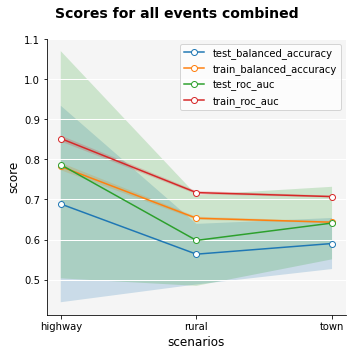

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotting_util as putil

plt.rcParams['figure.facecolor'] = 'white'

EVENTS = ['brake', 'brake_to_gas', 'gas', 'gas_to_brake', 'overtaking', 'road_sign', 'turning']

scores = ['test_balanced_accuracy', 'train_balanced_accuracy', 'test_roc_auc', 'train_roc_auc']

SCENARIOS = ['highway', 'rural', 'town']

fig, axes = putil.create_plot(nrows=1, ncols=1, sharey=True)
for ax in axes:
    putil.set_ax_visible_spines(ax, top=False, right=False)
putil.set_figure_size(fig, 5, 5)

avg_scores = []
avg_stddev = []
for scenario in SCENARIOS:
    results = pd.read_csv('out/results/{}_pred_results_events_{}.csv'.format(
                config.classifier, scenario), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
    avg_scores.append(results.loc['mean', scores])
    avg_stddev.append(results.loc['stddev', scores])
avg_scores = np.array(avg_scores)
avg_stddev = np.array(avg_stddev)
for i in range(avg_scores.shape[1]):
    axes[0].plot(range(len(SCENARIOS)), avg_scores[:, i], markerfacecolor='white', marker="o", label=scores[i])
    axes[0].fill_between(range(len(SCENARIOS)), y1=avg_scores[:, i]-avg_stddev[:, i], y2=avg_scores[:, i]+avg_stddev[:, i], alpha=0.2)
putil.set_ax_xticks(axes[0], range(len(SCENARIOS)), SCENARIOS)
putil.set_ax_axis_labels(axes[0], x_label='scenarios', y_label='score')
putil.set_ax_bg_color(axes[0], 'whitesmoke')
putil.set_ax_grid_lines(axes[0], True, axis="y", color="w")

plt.legend()
putil.set_fig_title(fig, title='Scores for all events combined', font_size=14, font_weight='bold')
plt.tight_layout()
plt.savefig('out/results/{}_scores_events_combined.png'.format(config.classifier))

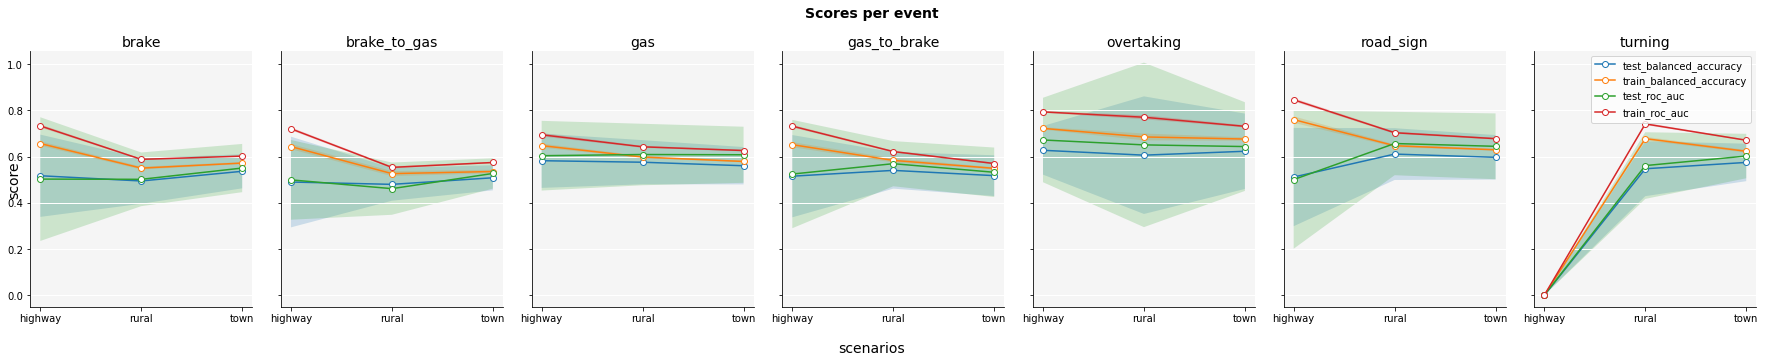

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotting_util as putil

plt.rcParams['figure.facecolor'] = 'white'

EVENTS = ['brake', 'brake_to_gas', 'gas', 'gas_to_brake', 'overtaking', 'road_sign', 'turning']

scores = ['test_balanced_accuracy', 'train_balanced_accuracy', 'test_roc_auc', 'train_roc_auc']

SCENARIOS = ['highway', 'rural', 'town']

fig, axes = putil.create_plot(nrows=1, ncols=len(EVENTS), sharey=True)
for ax in axes:
    putil.set_ax_visible_spines(ax, top=False, right=False)
putil.set_figure_size(fig, 25, 5)

for i, event in enumerate(EVENTS):
    avg_scores = []
    avg_stddev = []
    for scenario in SCENARIOS:
        if event == 'turning' and scenario == 'highway':
            avg_scores.append([0, 0, 0, 0])
            avg_stddev.append([0, 0, 0, 0])
        else:
            results = pd.read_csv('out/results/{}_pred_results_event_{}_{}.csv'.format(
                        config.classifier, event, scenario), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
            avg_scores.append(results.loc['mean', scores])
            avg_stddev.append(results.loc['stddev', scores])
    avg_scores = np.array(avg_scores)
    avg_stddev = np.array(avg_stddev)
    for j in range(avg_scores.shape[1]):
        axes[i].plot(range(len(SCENARIOS)), avg_scores[:, j], markerfacecolor='white', marker="o", label=scores[j])
        axes[i].fill_between(range(len(SCENARIOS)), y1=avg_scores[:, j]-avg_stddev[:, j], y2=avg_scores[:, j]+avg_stddev[:, j], alpha=0.2)
    putil.set_ax_xticks(axes[i], range(len(SCENARIOS)), SCENARIOS)
    putil.set_ax_title(axes[i], event)
    putil.set_ax_bg_color(axes[i], 'whitesmoke')
    putil.set_ax_grid_lines(axes[i], True, axis="y", color="w")

plt.legend()
putil.set_fig_title(fig, title='Scores per event', font_size=14, font_weight='bold')
putil.set_fig_xlabel(fig, 'scenarios')
putil.set_fig_ylabel(fig, 'score')
plt.tight_layout()
plt.savefig('out/results/{}_scores_per_event.png'.format(config.classifier))